# **Retrieve Company and Country Information**

In [ ]:
!pip install openai langchain langchain-community langchain-openai langgraph python-dotenv pypdf requests pandas semantic-router pinecone-client serpapi google-search-results pycountry wikipedia-api

In [3]:
!pip install -qU "langchain-community>=0.2.11" tavily-python

In [ ]:
pip install -U langchain langchain-openai pinecone-client

In [ ]:
import os
import json
import wikipediaapi
import pycountry
import requests

session = requests.Session()
session.timeout = 120  



USER_AGENT = "MyCountryInfoScript/1.0 (example@gmail.com)"


def get_country_info(country_name):
    """
    Fetches key facts about a country from Wikipedia, first by looking for structured sections,
    and then scanning the full text if necessary.

    Args:
        country_name (str): The name of the country to search for.

    Returns:
        dict: Dictionary containing country information.
    """
    # Initialize the Wikipedia API client with a custom User-Agent
    headers = {'User-Agent': USER_AGENT}
    wiki_wiki = wikipediaapi.Wikipedia('en', headers=headers)

    # Fetch the page for the country
    page = wiki_wiki.page(country_name)


    if not page.exists():
        print(f"Page for '{country_name}' does not exist on Wikipedia.")
        return None

    # Extract general country info
    country_info = {
        "Country": country_name,
        "Summary": page.summary[:2000],
        "Economy": None,
        "Culture": None,
        "Business Environment": None
    }


    for section in page.sections:
        title = section.title.lower()

        if "economy" in title:
            country_info["Economy"] = section.text[:2000]
        elif "culture" in title:
            country_info["Culture"] = section.text[:2000]
        elif any(keyword in title for keyword in ["business", "investment", "trade", "corporate"]):
            country_info["Business Environment"] = section.text[:2000]


    if not country_info["Economy"]:
        country_info["Economy"] = search_full_text_for_section(page.text, "economy")
    if not country_info["Culture"]:
        country_info["Culture"] = search_full_text_for_section(page.text, "culture")
    if not country_info["Business Environment"]:
        country_info["Business Environment"] = search_full_text_for_section(page.text, "business")


    for key in ["Economy", "Culture", "Business Environment"]:
        if country_info[key] is None:
            country_info[key] = "No relevant section found."

    return country_info

def search_full_text_for_section(full_text, keyword):
    """
    Scans the full text to find and return relevant information based on a keyword.

    Args:
        full_text (str): The full Wikipedia page text.
        keyword (str): The keyword to search for in the text.

    Returns:
        str: The relevant information extracted from the text.
    """
    start_index = full_text.lower().find(keyword)
    if start_index != -1:
        end_index = full_text.find("\n", start_index + 1000)
        return full_text[start_index:end_index].strip()
    return "Relevant information not found in full text."

def get_all_countries_info(json_file_path='files/all_countries_info.json'):
    """
    Fetches and saves information for all countries from Wikipedia into a single JSON file.

    Args:
        json_file_path (str): The file path where the JSON data will be saved.

    Returns:
        list: List of dictionaries containing country information.
    """

    os.makedirs(os.path.dirname(json_file_path), exist_ok=True)

    all_country_info = []


    country_names = [country.name for country in pycountry.countries]

    for country_name in country_names:
        print(f"Fetching data for {country_name}...")
        country_info = get_country_info(country_name)

        if country_info:
            all_country_info.append(country_info)

    # Save all data in one JSON file
    try:
        with open(json_file_path, 'w', encoding='utf-8') as f:
            json.dump(all_country_info, f, ensure_ascii=False, indent=4)
            print(f"All country data saved to {json_file_path}")
    except Exception as e:
        print(f"Error saving data: {e}")

    return all_country_info

if __name__ == "__main__":
    # Fetch and store all countries' info in one document
    all_countries_data = get_all_countries_info()


Fetching data for Aruba...
Fetching data for Afghanistan...
Fetching data for Angola...
Fetching data for Anguilla...
Fetching data for Åland Islands...
Fetching data for Albania...
Fetching data for Andorra...
Fetching data for United Arab Emirates...
Fetching data for Argentina...
Fetching data for Armenia...
Fetching data for American Samoa...
Fetching data for Antarctica...
Fetching data for French Southern Territories...
Fetching data for Antigua and Barbuda...
Fetching data for Australia...
Fetching data for Austria...
Fetching data for Azerbaijan...
Fetching data for Burundi...
Fetching data for Belgium...
Fetching data for Benin...
Fetching data for Bonaire, Sint Eustatius and Saba...
Fetching data for Burkina Faso...
Fetching data for Bangladesh...
Fetching data for Bulgaria...
Fetching data for Bahrain...
Fetching data for Bahamas...
Fetching data for Bosnia and Herzegovina...
Fetching data for Saint Barthélemy...
Fetching data for Belarus...
Fetching data for Belize...
Fetch

In [ ]:
import wikipediaapi
import concurrent.futures
import json
import re

# Custom User-Agent string for Wikipedia API request
USER_AGENT = "MyCompanyInfoScript/1.0 (example@gmail.com)"

def search_full_text_for_section(text, keyword):
    """
    Searches the full text for relevant information on a given keyword.

    Args:
        text (str): The full text of the Wikipedia page.
        keyword (str): The keyword to search for in the text.

    Returns:
        str: A substring of text (up to 1000 characters) starting at the keyword, or None.
    """
    lower_text = text.lower()
    lower_keyword = keyword.lower()
    if lower_keyword in lower_text:
        start_idx = lower_text.find(lower_keyword)
        end_idx = start_idx + 1000  
        return text[start_idx:end_idx]
    return None

def extract_industry_from_summary(summary):
    """
    Attempts to extract an industry phrase from the page summary.
    Looks for a pattern like "is a ... company".

    Args:
        summary (str): The summary text of the Wikipedia page.

    Returns:
        str: The captured industry phrase or None.
    """
    
    match = re.search(r"is a ([\w\s,&-]+?) (company|firm)", summary, re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return None

def get_company_info(company_name):
    """
    Fetches key facts about a company from Wikipedia.
    It extracts:
      - Background (from a section like "History")
      - Industry (from a dedicated section, a full-text search, or from the summary)
      - Achievements (from sections like "Business strategy", "Technology", or "Achievements")
      - Impact (from sections like "Lawsuits and controversies", "Corporate affairs", or "Impact")

    Args:
        company_name (str): The name of the company to search for.

    Returns:
        dict: A dictionary containing the company’s information.
    """
  
    wiki_wiki = wikipediaapi.Wikipedia(language='en', user_agent=USER_AGENT)
    page = wiki_wiki.page(company_name)

    if not page.exists():
        return {
            "Company": company_name,
            "Background": "No relevant section found.",
            "Industry": "No relevant section found.",
            "Achievements": "No relevant section found.",
            "Impact": "No relevant section found.",
            "Error": "Page not found"
        }

    company_info = {
        "Company": company_name,
        "Background": None,
        "Industry": None,
        "Achievements": None,
        "Impact": None
    }

    
    background_keywords = ["history"]
    background_text = None
    for section in page.sections:
        if any(keyword in section.title.lower() for keyword in background_keywords):
            background_text = section.text[:2000]  
            break
    if not background_text:
        background_text = page.text[:2000]  
    company_info["Background"] = background_text

    
    industry_keywords = ["industry", "sector", "products", "services", "automotive"]
    industry_text = None
    for section in page.sections:
        if any(keyword in section.title.lower() for keyword in industry_keywords):
            industry_text = section.text[:2000]  
            break
    
    if not industry_text:
        industry_text = search_full_text_for_section(page.text, "industry")
    
    if not industry_text:
        industry_text = extract_industry_from_summary(page.summary)
    company_info["Industry"] = industry_text or "No relevant section found."

    # --- Extract Achievements ---
    achievements_keywords = ["business strategy", "technology", "achievements"]
    achievements_text = None
    for section in page.sections:
        if any(keyword in section.title.lower() for keyword in achievements_keywords):
            achievements_text = section.text[:2000]
            break
    if not achievements_text:
        achievements_text = search_full_text_for_section(page.text, "achievements")
    company_info["Achievements"] = achievements_text or "No relevant section found."

    # --- Extract Impact ---
    impact_keywords = ["lawsuits and controversies", "corporate affairs", "impact"]
    impact_text = None
    for section in page.sections:
        if any(keyword in section.title.lower() for keyword in impact_keywords):
            impact_text = section.text[:2000]
            break
    if not impact_text:
        impact_text = search_full_text_for_section(page.text, "impact")
    company_info["Impact"] = impact_text or "No relevant section found."

    return company_info

def fetch_company_data_concurrently(company_names):
    """
    Fetches company data concurrently for multiple companies using threading.

    Args:
        company_names (list): List of company names.

    Returns:
        list: List of dictionaries with company information.
    """
    all_company_info = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(get_company_info, company_name) for company_name in company_names]
        for future in concurrent.futures.as_completed(futures):
            all_company_info.append(future.result())
    return all_company_info

if __name__ == "__main__":
    company_names = [
        "Apple", "Tesla", "Microsoft", "Google", "Amazon", "Facebook", "Netflix",
        "IBM", "Oracle", "Adobe", "Twitter", "Zoom", "Uber", "Airbnb", "Spotify",
        "Intel", "Nvidia", "Salesforce", "Snapchat", "LinkedIn", "Pinterest",
        "Lyft", "Slack", "Square", "Atlassian", "Shopify", "PayPal", "Stripe",
        "Dropbox", "Reddit", "Instacart", "Postmates", "Figma", "Robinhood",
        "Plaid", "ByteDance", "TikTok", "Alibaba", "Tencent", "Huawei", "Xiaomi",
        "Baidu", "JD.com", "Meituan", "Didi", "Zebra Technologies", "Palantir",
        "Databricks", "Snowflake", "Elastic", "MongoDB", "HashiCorp", "Twilio",
        "T-Mobile", "ZoomInfo", "Veeva", "Coupa", "Okta", "ServiceTitan",
        "Qualys", "Datadog", "Coupang", "Cognizant", "Accenture", "DXC Technology",
        "Intuit", "Cigna", "Aetna", "UnitedHealth", "CVS Health", "Merck", "Pfizer",
        "Eli Lilly", "Bristol-Myers Squibb", "AbbVie", "Johnson & Johnson",
        "Procter & Gamble", "Unilever", "Nestlé", "Coca-Cola", "PepsiCo",
        "General Electric", "Lockheed Martin", "Raytheon", "Ethio Telecom",
        "Ethiopian Airlines", "DHL Ethiopia", "Bunna International Bank",
        "Commercial Bank of Ethiopia", "Zemen Bank", "Awash International Bank",
        "Dashen Bank", "Addis Ababa Light Rail", "Mulugeta Teshome Group"
    ]

    company_data = fetch_company_data_concurrently(company_names)

    
    json_data = json.dumps(company_data, indent=4)
    with open("company_info.json", "w") as json_file:
        json_file.write(json_data)


In [ ]:
import os
import logging
import pandas as pd
import concurrent.futures
from typing import List, TypedDict, Dict, Any

from dotenv import load_dotenv

# External service clients and libraries
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Pinecone  # LangChain wrapper for Pinecone
from pinecone import Pinecone as PineconeClient, ServerlessSpec
from tavily import TavilyClient

# State graph for iterative workflows
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver


load_dotenv()  
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# Validate API keys from environment variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

if not all([OPENAI_API_KEY, PINECONE_API_KEY, TAVILY_API_KEY]):
    raise ValueError("Missing API keys. Please check your environment variables.")

# Initialize the OpenAI embedding function and Chat Model
embedding_function = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=OPENAI_API_KEY)
model = ChatOpenAI(model="gpt-4", temperature=0)

# Initialize the Tavily Client for external info retrieval
tavily = TavilyClient(api_key=TAVILY_API_KEY)

# Initialize Pinecone client and define the index name
pc = PineconeClient(api_key=PINECONE_API_KEY)
INDEX_NAME = "promptwithrag"


def manage_pinecone_index() -> None:
    """
    Ensure that the Pinecone index exists. If it doesn't, create the index using serverless specifications.
    """
    try:
        existing_indexes = pc.list_indexes().names()
        if INDEX_NAME in existing_indexes:
            logging.info(f"Index '{INDEX_NAME}' already exists.")
            return
        logging.info(f"Creating index '{INDEX_NAME}'...")
        spec = ServerlessSpec(cloud="aws", region="us-east-1")
        pc.create_index(name=INDEX_NAME, dimension=1536, metric="cosine", spec=spec)
        logging.info(f"Index '{INDEX_NAME}' created successfully.")
    except Exception as e:
        logging.exception(f"Error managing Pinecone index: {e}")


manage_pinecone_index()
index = pc.Index(INDEX_NAME)


# Data Loading & Preparation
def load_json_file(file_path: str) -> pd.DataFrame:
    """
    Loads a JSON file into a pandas DataFrame.
    Logs an error if the file is not found or if loading fails.
    """
    if not os.path.exists(file_path):
        logging.error(f"File not found: {file_path}")
        return pd.DataFrame()
    try:
        df = pd.read_json(file_path)
        logging.info(f"Loaded {len(df)} records from {file_path}")
        return df
    except Exception as e:
        logging.exception(f"Error loading file {file_path}: {e}")
        return pd.DataFrame()



countries_df = load_json_file("../files/all_countries_info.json")
companies_df = load_json_file("../files/company_info.json")


def combine_text_columns(df: pd.DataFrame, expected_columns: List[str], new_col_name: str) -> pd.DataFrame:
    """
    Combine specified text columns into a single column for further processing.
    If the expected columns are not found, all object-type columns are combined.
    """
    present_columns = [col for col in expected_columns if col in df.columns]
    if not present_columns:
        present_columns = df.select_dtypes(include="object").columns.tolist()
        logging.warning(f"Using all object columns for '{new_col_name}': {present_columns}")
    df[new_col_name] = df[present_columns].fillna("").agg(" ".join, axis=1)
    return df


countries_df = combine_text_columns(countries_df, ["Summary", "Economy", "Culture"], "country_description")
companies_df = combine_text_columns(companies_df, ["Background", "Industry", "Achievements", "Impact"], "company_description")


def chunk_documents(df: pd.DataFrame, text_column: str, source: str, chunk_size: int = 500, chunk_overlap: int = 50) -> List[Dict[str, Any]]:
    """
    Split document text into manageable chunks for embedding/upsertion.
    Skips documents that are too short.
    """
    result = []
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    for doc_idx, row in df.iterrows():
        text = row.get(text_column, "")
        if pd.isna(text) or len(text) < 100:
            continue  # Skip very short documents
        chunks = splitter.split_text(text)
        result.extend([
            {
                "doc_id": f"{source}_{doc_idx}",
                "chunk_id": i,
                "text": chunk,
                "source": source
            }
            for i, chunk in enumerate(chunks)
        ])
    return result


# Generate document chunks from both datasets
all_chunks = (
    chunk_documents(countries_df, "country_description", "country") +
    chunk_documents(companies_df, "company_description", "company")
)
df_chunks = pd.DataFrame(all_chunks)

# -----------------------------------------------------------------------------
# Upsert Embeddings into Pinecone
# -----------------------------------------------------------------------------
def upsert_embeddings() -> None:
    """
    Generate embeddings for each document chunk and upsert them into the Pinecone index.
    Uses batching with ThreadPoolExecutor to improve performance.
    """
    try:
        chunk_texts = df_chunks["text"].tolist()
        chunk_embeddings = embedding_function.embed_documents(chunk_texts)
    except Exception as e:
        logging.exception(f"Error generating embeddings: {e}")
        return

    # Prepare data for upsertion
    upsert_data = [
        (
            f"{row['doc_id']}_{row['chunk_id']}",
            chunk_embeddings[idx],
            {
                "doc_id": row["doc_id"],
                "chunk_id": row["chunk_id"],
                "text": row["text"],
                "source": row["source"]
            }
        )
        for idx, row in df_chunks.iterrows()
    ]

    def process_batch(batch):
        try:
            index.upsert(vectors=batch)
            return True
        except Exception as e:
            logging.exception(f"Error upserting batch: {e}")
            return False

    batch_size = 50
    batches = [upsert_data[i:i + batch_size] for i in range(0, len(upsert_data), batch_size)]
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_batch, batches))

    successful_batches = sum(1 for r in results if r)
    logging.info(f"Upsert completed with {successful_batches} successful batches out of {len(batches)}.")


upsert_embeddings()

# Create a retriever from the existing Pinecone vectorstore.
vectorstore = Pinecone.from_existing_index(index_name=INDEX_NAME, embedding=embedding_function)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [ ]:
class AgentState(TypedDict):
    company_name: str
    country_name: str
    company_info: str
    country_info: str
    draft_speech: str
    revision_number: int
    max_revisions: int
    retrieved_info: List[str]
    thread_id: str  # Used for checkpointing and session management

# Prompt templates for the agent's tasks.
COMPANY_INFO_PROMPT = """
Gather detailed information about {company_name}, including:
- Background
- Industry
- Achievements
- Impact
"""

COUNTRY_INFO_PROMPT = """
Provide key insights about {country_name}, including:
- Economic Landscape
- Cultural Significance
- Business Environment
"""

SPEECH_GENERATION_PROMPT = """
Create a compelling speech using the following information:

Company Information:
{company_info}

Country Information:
{country_info}

The speech should be formal, well-structured, and impactful for an invited guest.
"""

SPEECH_REVIEW_PROMPT = """
Review the speech and provide constructive feedback.
"""

# Agent Node Functions for the Workflow
def retrieve_company_info(state: AgentState) -> Dict[str, Any]:
    """
    Retrieve detailed company information using the Tavily service.
    """
    query = f"{state['company_name']} company overview, achievements, industry, and impact"
    try:
        response = tavily.search(query=query, max_results=3)
        if "results" in response:
            info = "\n".join([r["content"] for r in response["results"]])
        else:
            info = "Company information could not be retrieved."
    except Exception as e:
        logging.error(f"Error retrieving company info: {e}")
        info = "Error occurred while retrieving company information."
    return {"company_info": info}


def retrieve_country_info(state: AgentState) -> Dict[str, Any]:
    """
    Retrieve detailed country information using the Tavily service.
    """
    query = f"{state['country_name']} economic landscape, culture, and business environment"
    try:
        response = tavily.search(query=query, max_results=3)
        if "results" in response:
            info = "\n".join([r["content"] for r in response["results"]])
        else:
            info = "Country information could not be retrieved."
    except Exception as e:
        logging.error(f"Error retrieving country info: {e}")
        info = "Error occurred while retrieving country information."
    return {"country_info": info}


def retrieve_external_info(state: AgentState) -> Dict[str, Any]:
    """
    Retrieve additional external information from the vectorstore.
    """
    try:
        company_retrieval = retriever.invoke(f"{state['company_name']} company background")
        country_retrieval = retriever.invoke(f"{state['country_name']} country economic landscape")
        retrieved_info = company_retrieval + country_retrieval
    except Exception as e:
        logging.error(f"Error retrieving external info: {e}")
        retrieved_info = []
    return {"retrieved_info": retrieved_info}


def generate_speech(state: AgentState) -> Dict[str, Any]:
    """
    Generate a draft speech based on the company and country information.
    Also increments the revision counter.
    """
    prompt = SPEECH_GENERATION_PROMPT.format(
        company_info=state["company_info"],
        country_info=state["country_info"]
    )
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": "Generate the speech."},
    ]
    try:
        response = model(messages)
        draft_speech = response.content
    except Exception as e:
        logging.error(f"Error generating speech: {e}")
        draft_speech = "Error occurred during speech generation."
    return {"draft_speech": draft_speech, "revision_number": state["revision_number"] + 1}


def review_speech(state: AgentState) -> Dict[str, Any]:
    """
    Review the generated speech and provide constructive feedback.
    """
    messages = [
        {"role": "system", "content": SPEECH_REVIEW_PROMPT},
        {"role": "user", "content": state["draft_speech"]},
    ]
    try:
        response = model(messages)
        speech_review = response.content
    except Exception as e:
        logging.error(f"Error reviewing speech: {e}")
        speech_review = "Error occurred during speech review."
    return {"speech_review": speech_review}


def should_continue(state: AgentState) -> str:
    """
    Determine whether another revision is needed.
    Returns 'generate_speech' if more revisions are allowed, or END if the maximum is reached.
    """
    if state["revision_number"] > state["max_revisions"]:
        return END
    else:
        return "generate_speech"

In [ ]:
# Build the Workflow Graph
builder = StateGraph(AgentState)

# Add nodes (each representing a step in the workflow)
builder.add_node("fetch_company_info", retrieve_company_info)
builder.add_node("fetch_country_info", retrieve_country_info)
builder.add_node("retrieve_external_info", retrieve_external_info)
builder.add_node("generate_speech", generate_speech)
builder.add_node("review_speech", review_speech)

# Define the workflow:
builder.set_entry_point("fetch_company_info")
builder.add_edge("fetch_company_info", "fetch_country_info")
builder.add_edge("fetch_country_info", "retrieve_external_info")
builder.add_edge("retrieve_external_info", "generate_speech")
builder.add_edge("generate_speech", "review_speech")

builder.add_conditional_edges("review_speech", should_continue, {END: END, "generate_speech": "generate_speech"})

In [ ]:
# Enable checkpointing to preserve the agent state during execution
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


initial_state: AgentState = {
    "company_name": "Ethiopia Artificial Intelligence Institute",
    "country_name": "Ethiopia",
    "company_info": "",
    "country_info": "",
    "draft_speech": "",
    "revision_number": 1,
    "max_revisions": 3,
    "retrieved_info": [],
    "thread_id": "session_003"
}

try:
    output = graph.invoke(initial_state, config={"configurable": {"thread_id": "session_003"}})
    print("Agent Output:", output)
except Exception as e:
    logging.exception(f"Error invoking the agent: {e}")


2025-02-17 13:16:49,135 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-17 13:16:51,695 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-17 13:17:20,692 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 13:17:39,122 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 13:17:50,502 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 13:18:10,115 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 13:18:37,329 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 13:18:53,614 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Agent Output: {'company_name': 'Ethiopia Artificial Intelligence Institute', 'country_name': 'Ethiopia', 'company_info': "Overview:\nThe Ethiopian Artificial Intelligence Institute is involved in activities that protect the nation's interests through the use of artificial intelligence services, products, and solutions based on research, development, and implementation. It is also expected to foster a favorable climate for AI-related start-ups. Vision To be the premier African AI research and development center by 2030 and play a key role in creating innovative AI-enabled solutions. Mission Fostering the development of a nationally recognized AI ecosystem, skilled manpower, and AI-based systems to digitally empower and transform Ethiopia for peace and prosperity.\n\nWebsite: https://www.aii.et/\nCrunchbase Url: N/A\nLinkedin Url: https://www.linkedin.com/company/etartificialintelligenceinstitute\n\nIndustry:\nTechnology, Information and Internet\n\nCompany size:\n501-1,000 employees\n21

In [55]:
graph = builder.compile(checkpointer=memory)

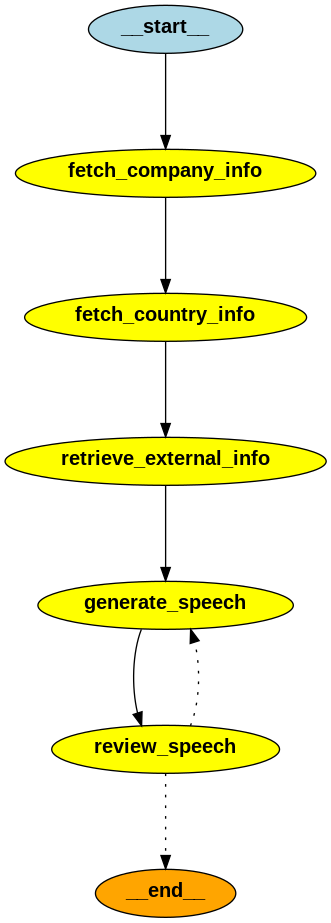

In [56]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [54]:
print(output["draft_speech"])

Ladies and Gentlemen,

I am honored to stand before you today to discuss the transformative work being done by the Ethiopian Artificial Intelligence Institute, or EAII. Founded in 2020, the EAII is a beacon of technological innovation in Ethiopia, and indeed, the entire African continent. Our mission is to foster the development of a nationally recognized AI ecosystem, skilled manpower, and AI-based systems to digitally empower and transform Ethiopia for peace and prosperity.

Our vision is ambitious, yet achievable. By 2030, we aim to be the premier African AI research and development center, playing a key role in creating innovative AI-enabled solutions. We are not just dreaming of a future where Ethiopia is a leader in AI technology; we are actively working towards it.

Our institute is involved in activities that protect the nation's interests through the use of artificial intelligence services, products, and solutions based on research, development, and implementation. We are also

In [57]:
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


initial_state: AgentState = {
    "company_name": "Ethiopia Airlines",
    "country_name": "Ethiopia",
    "company_info": "",
    "country_info": "",
    "draft_speech": "",
    "revision_number": 1,
    "max_revisions": 2,
    "retrieved_info": [],
    "thread_id": "session_003"
}

try:
    output = graph.invoke(initial_state, config={"configurable": {"thread_id": "session_003"}})
    print("Agent Output:", output)
except Exception as e:
    logging.exception(f"Error invoking the agent: {e}")


2025-02-17 13:30:59,082 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-17 13:31:02,459 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-17 13:31:38,928 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 13:31:55,098 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 13:32:31,966 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 13:32:47,881 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Agent Output: {'company_name': 'Ethiopia Airlines', 'country_name': 'Ethiopia', 'company_info': 'ETHIOPIAN THE LARGEST AIRLINE IN AFRICA FACT SHEET 2 Ethiopian Background Information Founded E December 21, 1945 Starting date of operation E April 08, 1946 Ownership E Government of Ethiopia (100%) Head Office E Bole International Airport, P .O. Box 1755 Addis Ababa, Ethiopia Fax: (+ 251)11661 1474 Reservations E Tel: (+251) 11 665 6666 Website E http://www.ethiopianairlines.com Chief Executive Officer E Mr. Tewolde GebreMariam Overview Ethiopian Airlines (Ethiopian) is the leading and most profitable airline in Africa. Tel: (+251-11) 517 8407/8656/8907/8165/8529/8913 Fax: (+251-11) 661 1474 E-mail:CorporateCommunication@ethiopianairlines.com www.twitter.com/flyethiopian www.youtube.com/flyethiopian www.facebook.com/ethiopianairlines.com http://plus.google.com/+ethiopianairlinescom http://instagram.com/fly.ethiopian www.ethiopianairlines.com Contact us on: Best Cargo Airline of the Year f

In [58]:
print(output['draft_speech'])

Ladies and Gentlemen,

I stand before you today to speak about a company that is not just an airline, but a symbol of national pride and a beacon of progress for an entire continent. Ethiopian Airlines, founded on December 21, 1945, and commencing operations on April 8, 1946, is the leading and most profitable airline in Africa. Owned entirely by the Government of Ethiopia, it has its headquarters at Bole International Airport in the vibrant city of Addis Ababa.

Under the dynamic leadership of our Chief Executive Officer, Mr. Tewolde GebreMariam, Ethiopian Airlines has soared to new heights, becoming "Africa's Link to the World." Each year, we serve more than 1.5 million passengers, connecting them to 22 domestic and 44 international destinations across four continents. Our commitment to excellence has been recognized globally, with Ethiopian Airlines being named the Best Cargo Airline of the Year from Africa at the 2016 Cargo Airline of the Year Air Cargo News awards.

But our journe